# Livrable 1 - Classification binaire

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from collections import Counter

In [38]:
dataset_dir = r'C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1'  

## Rescale (normalisation)

Le paramètre rescale=1./255 normalise les valeurs des pixels de l'image en les divisant par 255. Cela signifie que les valeurs des pixels, qui sont normalement dans la plage de 0 à 255 (puisque les images sont généralement encodées en 8 bits), sont mises à l'échelle pour être comprises entre 0 et 1.

In [39]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

## Split des données

80% train 
20% validation

In [40]:
batch_size = 32

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary', 
    subset='training'
)


validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 33120 images belonging to 2 classes.
Found 8279 images belonging to 2 classes.


### Création du modèle CNN 

In [41]:
model = Sequential()

In [42]:
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))


In [43]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [44]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [45]:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [46]:
model.add(Flatten())

In [47]:
model.add(Dense(128, activation='relu'))

In [48]:
model.add(Dropout(0.5))  # Dropout pour éviter le surapprentissage

In [49]:
model.add(Dense(64, activation='relu'))

In [50]:
model.add(Dense(1, activation='sigmoid'))

In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## Entrainement du modèle

In [53]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 591s 568ms/step - accuracy: 0.7870 - loss: 0.3939 - val_accuracy: 0.5405 - val_loss: 0.6369
Epoch 2/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 425s 410ms/step - accuracy: 0.8322 - loss: 0.3104 - val_accuracy: 0.5124 - val_loss: 0.6678
Epoch 3/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 415s 399ms/step - accuracy: 0.8334 - loss: 0.3087 - val_accuracy: 0.5300 - val_loss: 0.6518
Epoch 4/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 440s 424ms/step - accuracy: 0.8330 - loss: 0.3064 - val_accuracy: 0.5164 - val_loss: 0.6737
Epoch 5/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 438s 422ms/step - accuracy: 0.8456 - loss: 0.2835 - val_accuracy: 0.5450 - val_loss: 0.6571
Epoch 6/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 442s 426ms/step - accuracy: 0.8580 - loss: 0.2698 - val_accuracy: 0.5885 - val_loss: 0.6429
Epoch 7/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 425s 409ms/step - accuracy: 0.8665 - loss: 0.2653 - val_accuracy: 0.5462 - val_loss: 0.6739
Epoch 8/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 427s 411ms/step - ac

## Sauvegarde des poids

In [54]:
model.save_weights('model.weights.h5')

# Performance du modèle 

In [59]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

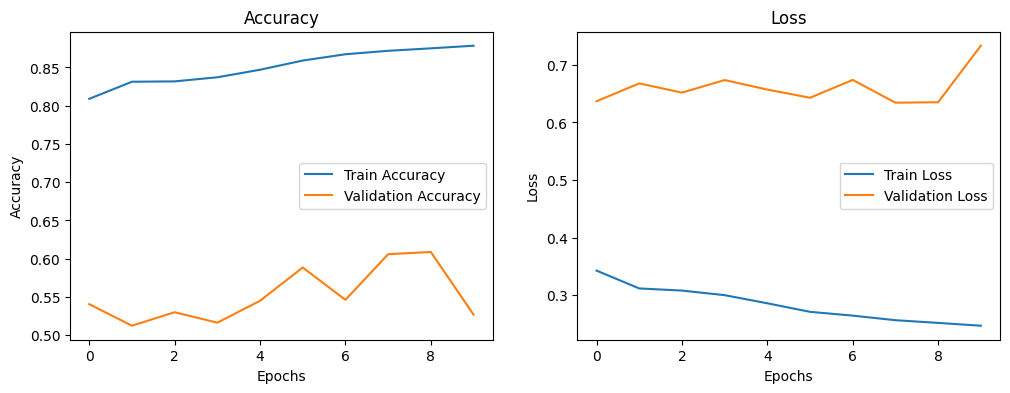

In [60]:
plot_training_history(history)

In [70]:

categories = ['Photo', 'Image'] 


def predict_image_binary_with_probabilities(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128)) 
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.  # Normaliser l'image

    # Prédiction binaire (une seule probabilité)
    predictions = model_save.predict(img_array)
    probability = predictions[0][0]  # Probabilité que l'image soit une "Photo"
    
    # Si la probabilité est > 0.5, c'est une Photo
    if probability > 0.5:
        predicted_class = 'Photo'
    else:
        predicted_class = 'Image'

    # Retourner la catégorie prédite et les probabilités
    return predicted_class, [probability, 1 - probability]  # Probabilité Photo, Probabilité Non-Photo

def display_images_with_binary_probabilities(model_save, dataset_dir, num_images=5):
    categories = ['Photo', 'Image']  # Seulement deux classes pour l'affichage
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 15))  # Grille avec 2 colonnes

    for i in range(num_images):
        # Choisir une image aléatoirement dans le dossier
        category = random.choice(categories)
        image_folder = os.path.join(dataset_dir, category)
        print(image_folder)
        try:
            random_image = random.choice(os.listdir(image_folder))
            image_path = os.path.join(image_folder, random_image)
            print(image_path)
            print(f"Image choisie aléatoirement : {image_path}")

            # Charger l'image et obtenir la prédiction et les probabilités
            img = load_img(image_path, target_size=(128, 128))
            predicted_class, probabilities = predict_image_binary_with_probabilities(model_save, image_path)

            # Afficher l'image
            axes[i, 0].imshow(img)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(f'{predicted_class}', fontsize=12)

            # Afficher l'histogramme des probabilités (pour les 2 classes)
            axes[i, 1].bar(range(len(categories)), probabilities, color='gray')
            axes[i, 1].set_xticks(range(len(categories)))
            axes[i, 1].set_xticklabels(categories, rotation=45, ha="right")
            axes[i, 1].set_title('Probabilités des classes')

        except PermissionError:
            print(f"Permission denied for accessing: {image_folder}. Skipping this folder.")
        except FileNotFoundError:
            print(f"File not found: {image_folder}. Skipping this folder.")
    
    plt.tight_layout()
    plt.show()


C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Photo
C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Photo\photo_0530.jpg
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Photo\photo_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Image
C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Image\Schematics
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Image\Schematics
Permission denied for accessing: C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Image. Skipping this folder.
C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Photo
C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_l

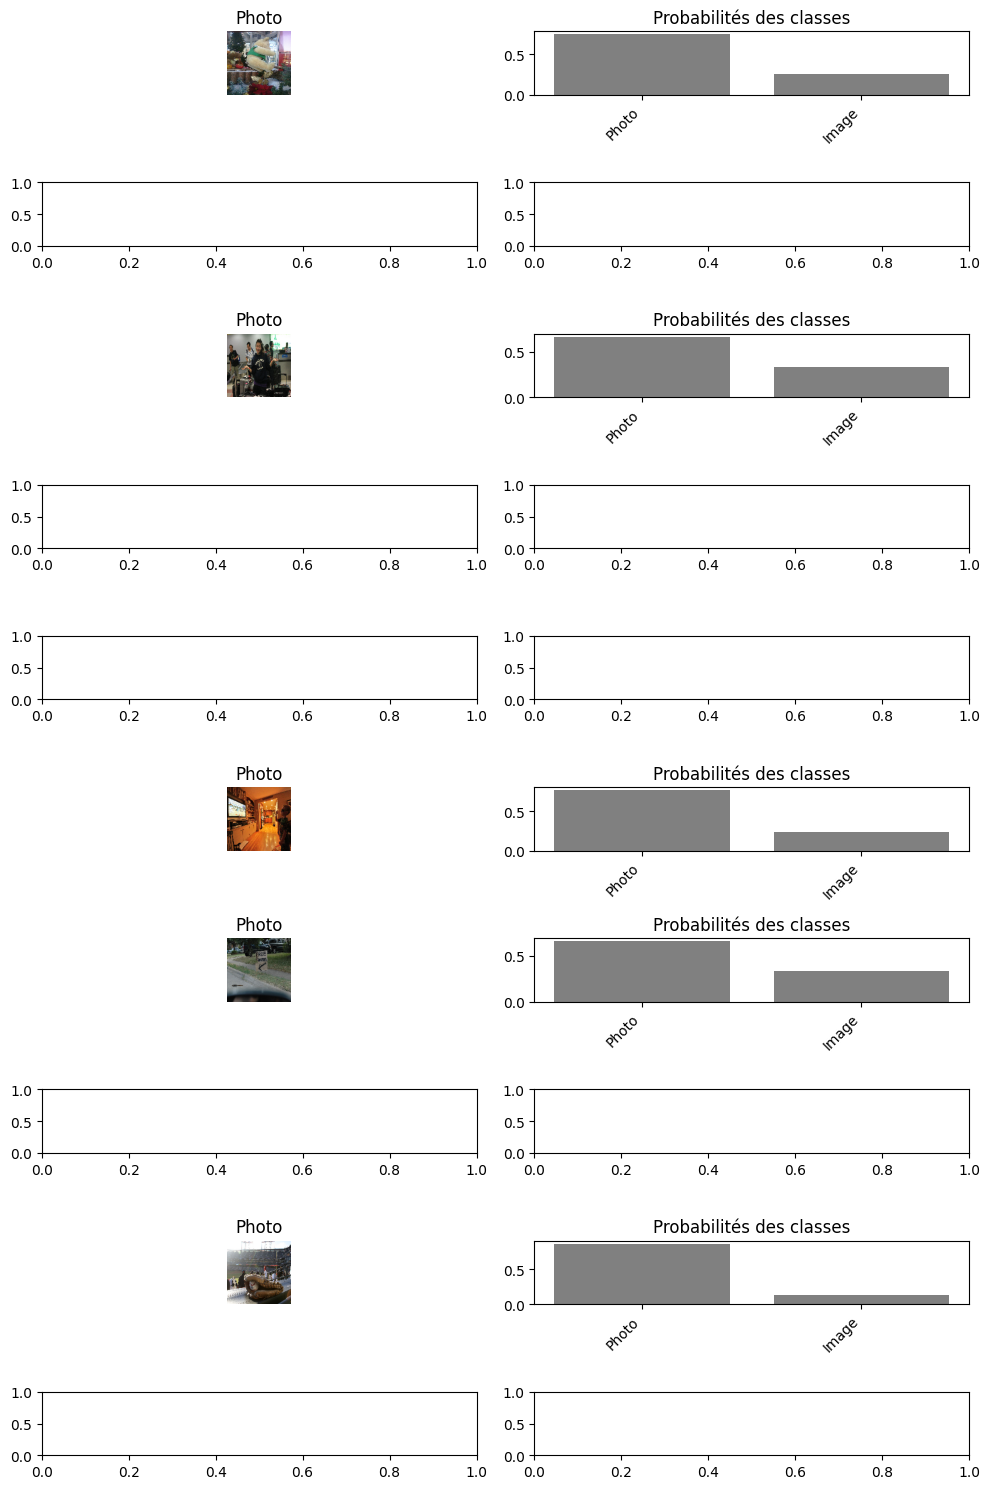

C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Image\Sketch


In [72]:
display_images_with_binary_probabilities(model, dataset_dir, num_images=10)

# Utilisation des Poids Sauvegarder


In [5]:
model_save_weights = Sequential()

In [6]:
model_save_weights.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))
model_save_weights.add(Conv2D(32, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(64, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(128, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Flatten())
model_save_weights.add(Dense(128, activation='relu'))
model_save_weights.add(Dropout(0.5)) 
model_save_weights .add(Dense(64, activation='relu'))


model_save_weights.add(Dense(1, activation='sigmoid'))

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model_save_weights.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model_save_weights.load_weights('model.weights.h5')

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Schematics\schematics_09573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Schematics\schematics_04903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Schematics\schematics_01943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Painting\painting_01408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Schematics\schematics_05772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc

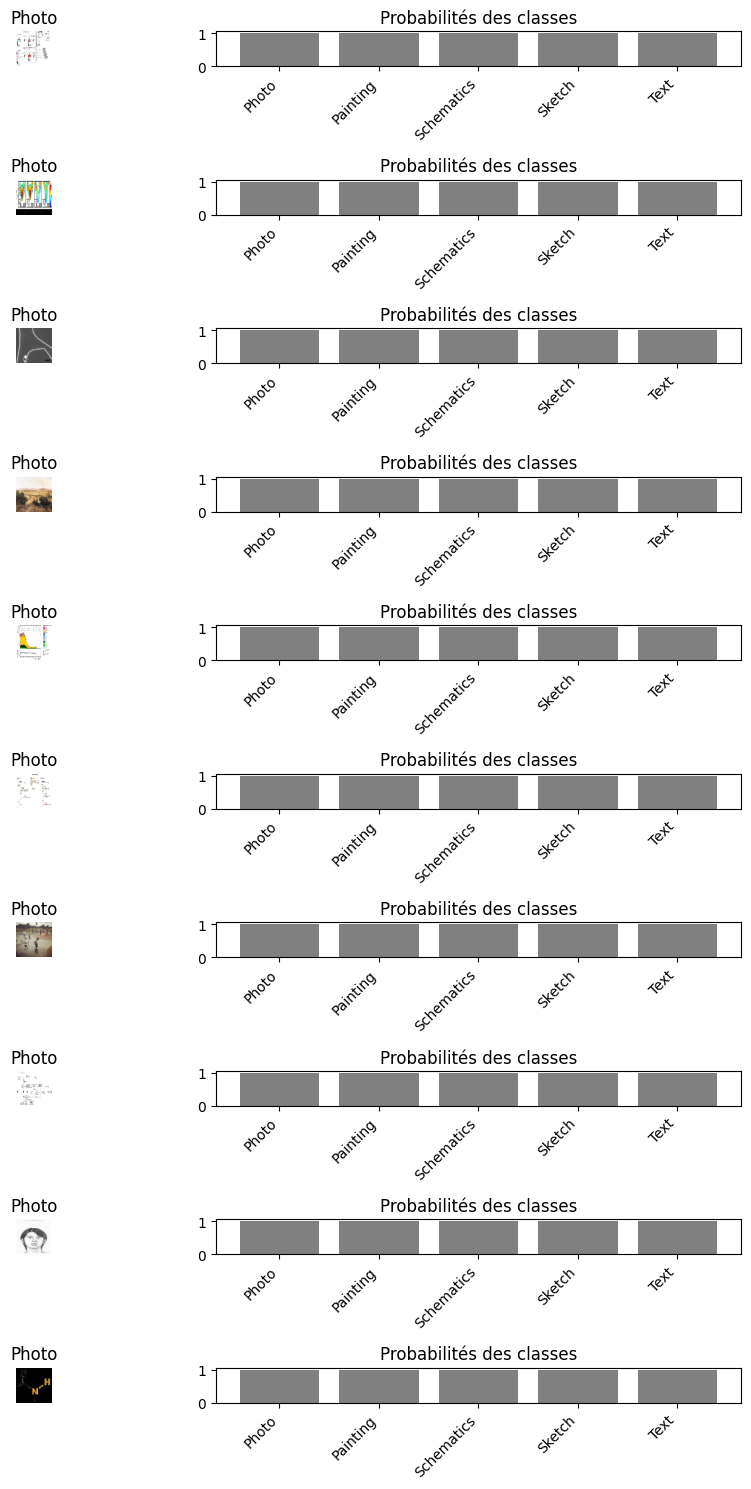

In [19]:
display_images_with_probabilities(model_save_weights, dataset_dir, num_images=10)